In [1]:
# Imports

import time
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.patches import Circle
from ripser import ripser
from persim import plot_diagrams
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.interpolate import CubicSpline
import tadasets
from itertools import combinations
%matplotlib inline

In [2]:
# Code for rowDetect and rowDetect2, both take as input a restricted coboundary and return the row where the equation no longer has a solution

# This function is called in rowDetect
def checkSolution(A, b):
    # Calculate the rank of the augmented matrix [A | b]
    augmented_matrix = np.column_stack((A, b))
    rank_A = np.linalg.matrix_rank(A)
    rank_augmented = np.linalg.matrix_rank(augmented_matrix)
    num_columns = A.shape[1]
    num_rows = A.shape[0]
    if rank_A == rank_augmented:
        if rank_A == num_columns:
            return 1
        elif rank_A < num_columns:
            return 1
    else:
        if rank_A < rank_augmented:
            return 0
    return "Unable to determine the solution status."

# This function is called in rowDetect2
def reductionAlgorithm(R):
    numRows = len(R)
    numColumns = len(R[0])
    #V = np.eye(numRows)
    pivotRows, pivotEntries = [[] for i in range (numColumns)], [[] for i in range (numColumns)]

    for i in range(numColumns):
        h = 0
        while (h == 0):
            pivotRow = np.inf
            for j in range(numRows - 1, -1, -1):
                if R[j][i] != 0:
                    pivotRow = j
                    break;
            if pivotRow == np.inf:
                pivotEntries[i] = 0
            else:
                pivotEntries[i] = R[pivotRow][i]
            pivotRows[i] = pivotRow
            if pivotRow == np.inf or all(pivotRows[k] != pivotRows[i] for k in range(i)):
                h = 1
                break;
            for k in range(i):
                if pivotRows[k] == pivotRows[i]:
                    c = pivotEntries[i] // pivotEntries[k]
                    for l in range(numRows):
                        R[l][i] -= c * R[l][k]
                        #V[l][i] -= c * V[l][k]
    barcode = []
    for i in range (numColumns):
        for k in range(i):
            if (pivotRows[i] == k):
                barcode.append([k + 1, i + 1])
                break;
        #else:
            #barcode.append([i + 1, np.inf])
            #print(f"[{i + 1}, inf)")
    return R, barcode

# rowDetect Code
def rowDetect(A, b):
    iMax = len(A) + 1
    iMin = 1
    i = len(A) // 2
    running = True
    while(running):
        sol = checkSolution(A[-i:], b[-i:])
        if sol == 0:
            if checkSolution(A[-(i - 1):], b[-(i - 1):]) == 1:
                row = len(A) - i
                running = False
                break;
            else:
                if i < iMax:
                    iMax = i
                    i = (iMax + iMin) // 2
        if sol == 1:
            if i > iMin:
                iMin = i
                i = (iMax + iMin) // 2
            if i == len(A):
                row = 0
                running = False
                break;
    return row

# rowDetect2 Code
def rowDetect2(A, b, rA):
    reduced = rA[0]
    barcode = rA[1]
    x = np.zeros(len(A[0])).T
    running = True
    row = 0
    i = len(A) - 1
    while (running and i > -1):
        for j in range(len(barcode)):
            if i == barcode[j][0]:
                x[barcode[j][1]] = b[i] - np.matmul(A[i], x)
                break;
            else:
                if np.matmul(A[i], x) == b[i]:
                    break;
                else:
                    row = i
                    running = False
                    break;
        i -= 1
    return row

In [3]:
# Other functions needed for finding and setting up the cup product vector and coboundary matrix
def SW_cloud(f, tau, d, n_data):
    x_vals = f[0]
    y_vals = f[1]
    cs = CubicSpline(x_vals, y_vals)
    t_vals = np.linspace(np.min(x_vals), np.max(x_vals)-tau, n_data)
    SW = np.zeros((n_data, d+1))
    for i, t in enumerate(t_vals):
        SW_f_t = cs(t + np.arange(0, d+1) * tau)
        SW[i] = SW_f_t
    return SW

def kmeans_downsampling(data, num_points): #Sampling
    kmeans = KMeans(n_clusters=num_points, random_state=0).fit(data)
    centroids = kmeans.cluster_centers_
    return centroids
num_points = 100

def cupProduct(phi, psi, triangleList): #Compute Cup Product
    cupProduct = []
    for i in range(len(triangleList)):
        phiVal = 0
        psiVal = 0
        for j in range(len(phi)):
            if phi[j][0] == triangleList[i][0] and phi[j][1] == triangleList[i][1]:
                phiVal = phi[j][2]
                break;
        for k in range(len(psi)):
            if psi[k][0] == triangleList[i][1] and psi[k][1] == triangleList[i][2]:
                psiVal = psi[k][2]
                break;
        cupProduct.append(phiVal * psiVal)
    cupProduct = np.array(cupProduct).T
    return cupProduct

def rowTriangle(r):
    value=len(triangles)-r
    return triangles[value]

In [4]:
#Generate a shape

np.random.seed(2) #This for a torus
n_data = 25000
R = 5
r = 2
data = np.zeros((3, n_data))
s = np.random.rand(n_data)*2*np.pi
t = np.random.rand(n_data)*2*np.pi
data[0] = (R + r*np.cos(s))*np.cos(t)
data[1] = (R + r*np.cos(s))*np.sin(t)
data[2] = r*np.sin(s)
data += 0.1*np.random.randn(*data.shape)

In [22]:
# Alternate Mickey Mouse, smaller ears

# Circle 1 / Left Ear
np.random.seed(1122)
n_data = 10000

theta = np.linspace(0, 2*np.pi, n_data)
circle1Data = np.zeros((3, n_data))

circle1Data[0] = 2 * np.sin(theta) - 8
circle1Data[1] = 0
circle1Data[2] = 2 * np.cos(theta)

# Circle 2 / Right Ear
theta = np.linspace(0, 2*np.pi, n_data)
circle2Data = np.zeros((3, n_data))

circle2Data[0] = 1.5 * np.sin(theta) + 7.5
circle2Data[1] = 0
circle2Data[2] = 1.5 * np.cos(theta)

# Sphere / Head
n_data = 100
theta = np.linspace(0, np.pi, n_data)
phi = np.linspace(0, 2*np.pi, n_data)
sphereData = np.zeros((3, n_data**2))
phi, theta = np.meshgrid(phi, theta)

sphereData[0] = 6 * (np.sin(theta) * np.cos(phi)).flatten()
sphereData[1] = 7 * (np.sin(theta) * np.sin(phi)).flatten()
sphereData[2] = 1.5 * (np.cos(theta)).flatten()

# Plot the Data
data = np.hstack((circle1Data, sphereData, circle2Data))

fig = go.Figure(data=[go.Scatter3d(
    x=data[0], y=data[1], z=data[2], 
    mode ='markers', 
    marker=dict(size = 3 , color = 'grey'))])
#fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False)
fig.update_layout(scene= dict(zaxis = dict(range=[-5, 5])))
fig.show()

The sliding window point cloud has shape (5000, 4)


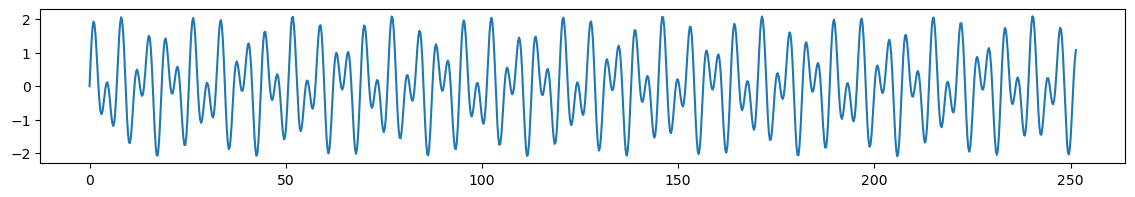

In [31]:
#Quasiperiodic time series
x_vals = np.linspace(0 , 80*np.pi, 1000)
y_vals = np.sin(x_vals) + 1.1*np.sin(np.sqrt(3)*x_vals)
plt.figure(figsize = (14,2))
plt.plot(x_vals, y_vals);
f = np.array([x_vals, y_vals]) ## <---- toy time series
d = 3
tau = 1.5
n_data = 5000
SW = SW_cloud(f, tau, d, n_data)
print('The sliding window point cloud has shape', SW.shape)

fig = go.Figure(data=[go.Scatter3d(
    x=SW[:,0], y=SW[:,1], z=SW[:,2], 
    mode ='markers', 
    marker=dict(size = 1.5, color = 'grey')
)] , layout = go.Layout(scene = dict(aspectmode= 'data')))
fig.show()

In [36]:
# Code for finding cup product vector and coboundary matrix
start_time=time.time()
#x = kmeans_downsampling(data.T, 110)
n_landmarks = 185
x = SW
result = ripser(x, coeff=2, n_perm = n_landmarks, maxdim = 2, do_cocycles=True)
#result = ripser(x, coeff=2, maxdim = 2, do_cocycles=True)
diagrams = result['dgms']
cocycles = result['cocycles'] #all of the cocycles
D = result['dperm2all'] #distance matrix between the ith and jth points in the data
dgm1 = diagrams[1]
#Representative cocycle phi
idx1 = np.argmax(dgm1[:, 1] - dgm1[:, 0])
cocycle1 = cocycles[1][idx1]
#Representative cocycle psi
sorted_indices = np.argsort(dgm1[:, 1] - dgm1[:, 0])
idx2 = sorted_indices[-2]
cocycle2 = cocycles[1][idx2]

#Restrict cocycle1
New_cocycle1=[]
edges=[]
for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i:i-1, :2], cocycle1[i:i+1, :2], cocycle2[j:j+1, :2]):  
                New_cocycle1.append(cocycle2[j:j+1])
        New_cocycle1.append(cocycle2[i:i+1])        
rcocycle1=np.vstack(New_cocycle1)
for i in range(len(cocycle1)):
        for j in range(len(cocycle2)):
            if np.array_equal(cocycle1[i-1:i, :2], cocycle2[j:j+1, :2]):
                edges.append(cocycle2[j:j+1])  
if len(edges) > 0:
    edges=np.vstack(edges)
for i in range(len(rcocycle1)):
    found_match = False
    for j in range(len(edges)):
        if np.array_equal(rcocycle1[i, :2], edges[j, :2]):
            found_match = True
            break
    if not found_match:
        rcocycle1[i, -1] = 0
        
# Finding the representative cocycles for triangles
representative_cocycles = []
for i in range(len(dgm1)):
    birth, death = dgm1[i]
    if birth != death:  # ignore points on the diagonal
        cocycle = cocycles[1][i]
        representative_cocycles.append(cocycle)
triangles = []
for cocycle in representative_cocycles:
    edge_indices = cocycle[:, :2].astype(int)
    triangle_vertices = set()
    for i, j in edge_indices:
        triangle_vertices.add(i)
        triangle_vertices.add(j)
    triangle_combinations = combinations(triangle_vertices, 3)
    for combination in triangle_combinations:
        triangles.append(list(combination))
t=np.vstack(triangles)

cup=cupProduct(rcocycle1,cocycle2, t)#Compute the cup Product
cup=np.vstack(cup)

#Part 2: Get the Coboundary Matrix
edges = []
vertices=[]
representative_cocycles = []
for i in range(len(dgm1)):
    birth, death = dgm1[i]
    if birth != death:  
        cocycle = cocycles[1][i]
        representative_cocycles.append(cocycle)
for cocycle in representative_cocycles: # Extracting every edge as an array of vertices
    edge_indices = cocycle[:, :2].astype(int)
    for i, j in edge_indices:
        edge = [i, j]
        edges.append(edge)
for cocycle in representative_cocycles: #Extracting every vertex
    vertex_indices = cocycle[:, :1].astype(int)
    for i in vertex_indices:
        vertices.append(i[0])
vertices = list(set(vertices)) # Remove duplicate vertices by converting the list to a set and then back to a list

ne = len(edges)
nt = len(triangles)
nv = len(vertices)
num_rows= ne+nt+nv
num_cols=ne+nt+nv
boundary_matrix=np.zeros((num_rows, num_cols), dtype=int)
for i,edge in enumerate(edges):
    a,b=edge #a and b are the two verticies that make up the edge
    for j,vertex in enumerate(vertices):
        c=vertex # c is a vertex
        if b == c:
            boundary_matrix[nv+i,j]=1
        if a == c:
            boundary_matrix[nv+i,j]=-1
for i, triangle in enumerate(triangles):
    e,f,g=triangle #e,f,g are verticies in the triangle
    for j,edge in enumerate(edges):
        h,k=edge 
        if (h,k) == (e,f):
            boundary_matrix[(ne+nv)+i,nv+j]=1
        if (h,k) == (f,g):
            boundary_matrix[(ne+nv)+i,nv+j]=1
        if (h,k) == (e,g):
            boundary_matrix[(ne+nv)+i,nv+j]=-1
boundary_matrix=boundary_matrix.T
#Convert Boundary Matrix into Coboundary
restricted_matrix = boundary_matrix[nv:nv + ne, nv + ne:len(boundary_matrix)]
coboundary_matrix = np.flip(restricted_matrix).T

In [37]:
# Bisection Method

profiler = cProfile.Profile()
profiler.enable()

detect = rowDetect(coboundary_matrix, cup)
print(detect)

profiler.disable()
profiler.print_stats()

87269
         2835 function calls (2695 primitive calls) in 14.385 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       28    0.001    0.000   14.301    0.511 1295700796.py:4(checkSolution)
        1    0.084    0.084   14.385   14.385 1295700796.py:62(rowDetect)
        1    0.000    0.000    0.000    0.000 2592173556.py:1(<module>)
       28    0.000    0.000    0.709    0.025 <__array_function__ internals>:177(column_stack)
       28    0.000    0.000    0.708    0.025 <__array_function__ internals>:177(concatenate)
       56    0.000    0.000    0.003    0.000 <__array_function__ internals>:177(count_nonzero)
       56    0.000    0.000   13.591    0.243 <__array_function__ internals>:177(matrix_rank)
       56    0.000    0.000   13.581    0.243 <__array_function__ internals>:177(svd)
       56    0.000    0.000    0.002    0.000 _methods.py:38(_amax)
       56    0.000    0.000    0.001    0.000 _methods.py:46(_sum

In [38]:
# Reduce Matrix

reduced = reductionAlgorithm(coboundary_matrix)
A = reduced[0]

In [39]:
# Backsubstitution Method

profiler.enable()

detect = rowDetect2(A, cup, reduced)
print(detect)

profiler.disable()
profiler.print_stats()

87269
         10029 function calls (9889 primitive calls) in 14.443 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       28    0.001    0.000   14.301    0.511 1295700796.py:4(checkSolution)
        1    0.084    0.084   14.385   14.385 1295700796.py:62(rowDetect)
        1    0.057    0.057    0.057    0.057 1295700796.py:89(rowDetect2)
        1    0.000    0.000    0.000    0.000 2592173556.py:1(<module>)
        1    0.000    0.000    0.000    0.000 2596612137.py:1(<module>)
       28    0.000    0.000    0.709    0.025 <__array_function__ internals>:177(column_stack)
       28    0.000    0.000    0.708    0.025 <__array_function__ internals>:177(concatenate)
       56    0.000    0.000    0.003    0.000 <__array_function__ internals>:177(count_nonzero)
       56    0.000    0.000   13.591    0.243 <__array_function__ internals>:177(matrix_rank)
       56    0.000    0.000   13.581    0.243 <__array_function__ inter

In [ ]:
# Rest of code
tri=rowTriangle(detect) #Obtain associated triangle with the detected row
sorted_indices = np.argsort(dgm1[:, 1] - dgm1[:, 0])
idx = sorted_indices[-2]
h = max(dgm1[idx1, 0], dgm1[idx2, 0])
birth=dgm1[idx2,1]
while h < birth:
    newRun = ripser(x, coeff=2, n_perm = n_landmarks, thresh = h, do_cocycles = True)
    newDiagrams = newRun['dgms']
    newCocycles = newRun['cocycles']
    D = newRun['dperm2all']
    dgmNew = newDiagrams[1]
    new_representative_cocycles = []
    for i in range(len(dgmNew)):
        #birth = dgmNew[i]
        #if birth != death:  # ignore points on the diagonal
        newCocycle = newCocycles[1][i]
        new_representative_cocycles.append(newCocycle)
    newTriangles = []
    for newCocycle in new_representative_cocycles:
        edge_indices = newCocycle[:, :2].astype(int)
        new_triangle_vertices = set()
        for i, j in edge_indices:
            new_triangle_vertices.add(i)
            new_triangle_vertices.add(j)
        new_triangle_combinations = combinations(new_triangle_vertices, 3)
        for combination in new_triangle_combinations:
            newTriangles.append(list(combination))
    #newT = newTriangles
    if len(newTriangles) > 0:
        newT=np.vstack(newTriangles)
        for k in range(len(newT)):
            if newT[k][0] == tri[0] and newT[k][1] == tri[1] and newT[k][2] == tri[2]:
                death=h #Gives the Cohomological death
                h = 1000000
                break;
    h += 0.1
    
print("finished part 7")

#Part 4: Plot the persistence diagram with the new point
birth=dgm1[idx2,1] #death of psi but birth of H2 point 
plot_diagrams(diagrams, show = False)
#plt.scatter(dgm1[0], dgm1[1], 20)
plt.scatter(death,birth, color='g')
plt.title("Persistence Diagram")
plt.show()
end_time=(time.time()-start_time)
print("Time Elapsed =",end_time)